In [4]:
import pandas as pd
import time
import numpy as np
import re
import pickle
import string, unicodedata
from unidecode import unidecode
#from modulku import praproses as pps
from sklearn.decomposition import PCA

## Load Data

In [7]:
data_ = pd.read_excel('data/data_bersih_ngram_+stemmer_.xlsx')
latih_cm = data_['komentar'].tolist()
label_cm = data_['label'].tolist()
len(latih_cm)

3074

## Seleksi Fitur

In [8]:
#proses membuat vocabularry
from sklearn.feature_extraction.text import TfidfVectorizer
kosa_kata = set()

###seleksi fitur
kk = TfidfVectorizer()
kk.fit_transform(latih_cm)
kosa_kata = kk.get_feature_names()
print(len(kosa_kata))
with open('model/feature_balance_n_gram.txt', 'w') as f:
    for item in kosa_kata:
        f.write("%s\n" % item)

1977


## Proses TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
#membuat TF-IDF
f = open("model/feature_balance_n_gram.txt")
kosa_kata = f.read().split()

tfidf = TfidfVectorizer(vocabulary = kosa_kata)

tfidf_matrix_ = tfidf.fit_transform(latih_cm) #For CM
print(tfidf_matrix_.shape)
X_ = tfidf_matrix_.toarray()
X = X_
Y_ = np.array(label_cm)
Y = Y_

(3074, 1977)


## Plot Bar Label Dataset

Positive    1691
Negative    1383
Name: label, dtype: int64


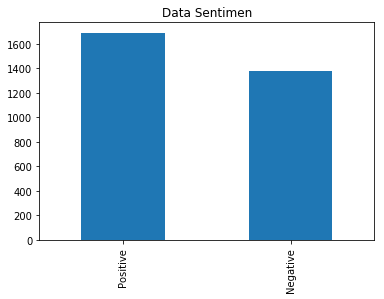

In [12]:
pca = PCA(n_components=2)
pd.value_counts(data_['label']).plot.bar(title='Data Sentimen')
print(pd.value_counts(data_['label']))

## Proses Pemodelan

In [13]:
#Import Library
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score

### Input parameter

In [14]:
#Parameter SVM
C = 1.8
gamma = 0.6

## K-Fold Cross Validation 
### jalanin aja dulu

In [15]:
K = 10 #pembagian data uji dan data latih
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score #, precision_score, recall_score
kf= KFold(n_splits=K) 

cSVM = svm.SVC(kernel='rbf', gamma=gamma, C=C)

akurasi_svm = []

for train_index, test_index in kf.split(X):
    #membagi data latih dan data uji
    X_train, X_test = X[train_index], X[test_index] #pembagian data latih
    y_train, y_test = Y[train_index], Y[test_index]
    
    #Melatih Model 
    mSVM = cSVM.fit(X_train, y_train) #SVM

    #proses prediksi
    P_SVM = mSVM.predict(X_test)

    #menyimpan hasil akurasi tiap iterasi
    akurasi_svm.append(accuracy_score(y_test, P_SVM))
    
rerata_akurasi_svm = sum(akurasi_svm)/len(akurasi_svm)

print("Hasil K-Fold SVM")
print("   Rerata akurasi           :",rerata_akurasi_svm)
print("   Rerata akurasi (round)   :",round(rerata_akurasi_svm,2))
dic1 = {"iterasi ke-":[x+1 for x in range(10)], "akurasi":akurasi_svm}
pd.DataFrame.from_dict(dic1)

Hasil K-Fold SVM
   Rerata akurasi           : 0.995772875333136
   Rerata akurasi (round)   : 1.0


,iterasi ke-,akurasi
0,1,0.996753
1,2,0.996753
2,3,0.996753
3,4,0.987013
4,5,0.993485
5,6,0.993485
6,7,1.000000
7,8,0.993485
8,9,1.000000
9,10,1.000000


# Hanya coba (belum menggunakan data baru)
## Proses Confusion Matrix untuk SVM

Positive    1659
Negative    1365
Name: label, dtype: int64

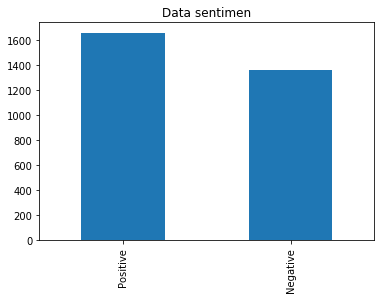

In [17]:
index_train = [x for x in range(3024)]
cm_Y = Y_[index_train]
dc = {"label":cm_Y}
cd = pd.DataFrame(dc, columns=['label'])
pd.value_counts(cd['label']).plot.bar(title='Data sentimen')
pd.value_counts(cd['label'])

In [18]:
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix


index_train = [x for x in range(3024)]
index__test = [x for x in range(3024, 3074)]

cm_X = X_[index_train]
cm_Y = Y_[index_train]
cm_X_test = X_[index__test]
cm_Y_test = Y_[index__test]

X_train = cm_X
X_test = cm_X_test

y_train = cm_Y
y_test = cm_Y_test

class_names = ['Positive', 'Negative']

classifier = svm.SVC(kernel='rbf', C=C, gamma=gamma) #Model SVM
y_pred = classifier.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
print("SVM")
cnf_matrix = confusion_matrix(y_test, y_pred) # inti
print(cnf_matrix)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
tp= cm [0][0]
fn= cm [0][1]
fp= cm [1][0]
tn= cm [1][1]
cm_akurasi = (tp+tn)/(tp+tn+fp+fn)
cm_precision = tp/(tp+fp)
cm_recall = tp/(tp+fn)

f_measure = 2*(cm_precision*cm_recall)/(cm_precision+cm_recall)
print("   F-Measure (SVM)")
print("   ----------------")
print("   akurasi   : ", cm_akurasi)
print("   precision : ", cm_precision)
print("   recall    : ", cm_recall)
print("   f-Measure : ", f_measure)

SVM
[[18  0]
 [ 0 32]]
   F-Measure (SVM)
   ----------------
   akurasi   :  1.0
   precision :  1.0
   recall    :  1.0
   f-Measure :  1.0


## Menyimpan model

In [19]:
cSVM = svm.SVC(kernel='rbf', gamma=gamma, C=C)
#Melatih Model untuk data secara keseluruhan (X dan Y)
cSVM = cSVM.fit(X, Y) #SVN

#save models
filename = 'model\cSVM_imbang_With_N-Gram.irham'
pickle.dump(cSVM, open(filename, 'wb'))
